In [ ]:
# You need to activate the GPU before running this session
# Edit > Notebook settings or Runtime>Change runtime type and select GPU as Hardware accelerator.
# This will run your GPU instead of your RAM
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

DATADIR = "/content/drive/MyDrive/Sucellus Dataset/Train"
CATEGORIES = ['Fire',"Neutral","Smoke"]

# Firstly we must upload the data to system so that we can resize it

for category in CATEGORIES:
    path = os.path.join(DATADIR,category)
    for img in os.listdir(path):
          bgr_array = cv2.imread(os.path.join(path,img)) #OpenCv takes the parameters as BGR (Blue Green Red)
          img_array = bgr_array[:, :, [2, 1, 0]]  #Thats why we need to convert this values to have RGB
          break
    break

# If we had to work with multiple projects at same GPU we had to use this code
#gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction = 0.33)
#sess = tf.Session(config = tf.ConfigProto(gpu_options = ))

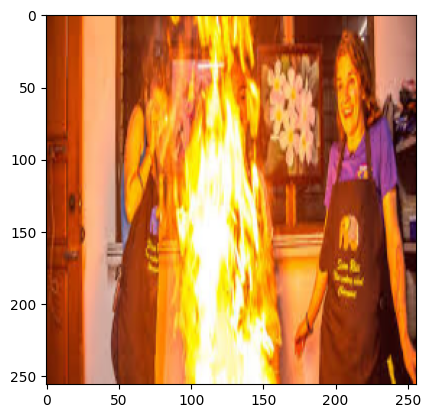

In [ ]:
# Reshaping the image

IMG_SIZE =  256
new_array = cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
plt.imshow(new_array)
plt.show()

In [ ]:
# Creating train data

training_data = []

def create_training_data():
  for category in CATEGORIES:
    path = os.path.join(DATADIR,category)
    class_num = CATEGORIES.index(category) # 0 = fire , 1 = other , 2 = other
    for img in os.listdir(path):
      try:
           bgr_array = cv2.imread(os.path.join(path,img))
           img_array = bgr_array[:, :, [2, 1, 0]]
           new_array = cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
           training_data.append([new_array,class_num])
      except Exception as e:
        pass

create_training_data()

In [ ]:
# finding out our usable data number

print(len(training_data))

1626


In [ ]:
# Shuffling the data for better learning

import random
random.shuffle(training_data)

In [ ]:
for sample in training_data[:3]:
  #plt.imshow(sample[0])    normally we can see the images by this
  #plt.show()               but since the compiling time is important we can see like this
  print(sample[1])

0
0
2


In [ ]:
# preparing feature and label array

X = []
y = []

In [ ]:
#Converting and reshaping data
for features, label in training_data:
  X.append(features)
  y.append(label)

X = np.array(X).reshape(-1,IMG_SIZE,IMG_SIZE,3)

In [ ]:
# saving data to use in project
import pickle
pickle_out = open("X.pickle","wb")
pickle.dump (X,pickle_out)
pickle_out.close()

pickle_out = open("y.pickle","wb")
pickle.dump (y,pickle_out)
pickle_out.close()



In [ ]:
#loading data
import pickle
X = pickle.load(open("X.pickle","rb"))
y = pickle.load(open("y.pickle","rb"))

X = X/255.0

In [ ]:
# Model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,Activation, BatchNormalization
from tensorflow.keras.layers import Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import regularizers
import time

# Saving the model
NAME = "sucellus{}".format(int(time.time()))
tensorboard = TensorBoard(log_dir = 'logs/{}'.format(NAME))

# Building the model
model = Sequential()

model.add(Conv2D(128,(3,3),input_shape = X.shape[1:]))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))


model.add(Conv2D(64,(3,3),input_shape = X.shape[1:]))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(128,kernel_regularizer=regularizers.l2(0.001)))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(64,kernel_regularizer=regularizers.l2(0.001)))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.2))


model.add(Dense(3))
model.add(Activation('softmax'))

model.compile(loss = "sparse_categorical_crossentropy",
              optimizer ='adam',
              metrics = ['accuracy'])


model.fit(X,
          y=np.array(y),
          batch_size = 64,
          steps_per_epoch=16,
          epochs = 20,
          validation_split = 0.15,
          callbacks =[tensorboard] )

Epoch 1/10
14/14 [==============================] - 6s 148ms/step - loss: 4.3543 - accuracy: 0.6295 - val_loss: 0.4892 - val_accuracy: 0.8033
Epoch 2/10
14/14 [==============================] - 1s 70ms/step - loss: 0.5031 - accuracy: 0.7969 - val_loss: 0.3581 - val_accuracy: 0.8566
Epoch 3/10
14/14 [==============================] - 1s 71ms/step - loss: 0.4397 - accuracy: 0.8304 - val_loss: 0.3776 - val_accuracy: 0.8607
Epoch 4/10
14/14 [==============================] - 1s 83ms/step - loss: 0.3787 - accuracy: 0.8460 - val_loss: 0.3464 - val_accuracy: 0.8770
Epoch 5/10
14/14 [==============================] - 1s 71ms/step - loss: 0.3228 - accuracy: 0.8728 - val_loss: 0.3480 - val_accuracy: 0.8566
Epoch 6/10
14/14 [==============================] - 1s 80ms/step - loss: 0.3618 - accuracy: 0.8862 - val_loss: 0.3610 - val_accuracy: 0.8730
Epoch 7/10
14/14 [==============================] - 1s 70ms/step - loss: 0.2904 - accuracy: 0.8910 - val_loss: 0.3581 - val_accuracy: 0.8607
Epoch 8/10
1

In [ ]:
# Saving the model
model.save(NAME)
new_model = tf.keras.models.load_model(NAME)

In [ ]:
# Testing the prediction
CATEGORIES = ['Fire','Smoke','Neutral']
def prepare(filepath):
  IMG_SIZE = 256
  bgr_array = cv2.imread(os.path.join(path,img))
  img_array = bgr_array[:, :, [2, 1, 0]]
  new_array = cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
  return new_array.reshape(-1,IMG_SIZE,IMG_SIZE,3)
model = tf.keras.models.load_model(NAME)

In [ ]:
prediction = model.predict([prepare('fire.jpg')])
print(CATEGORIES[int(prediction[0][0])])

1/1 [==============================] - 0s 153ms/step
Smoke


In [ ]:
prediction = model.predict([prepare('/content/drive/MyDrive/Sucellus Dataset/Train/Neutral/image_10.jpg')])
print(CATEGORIES[int(prediction[0][0])])

1/1 [==============================] - 0s 21ms/step
Smoke
